# 01 - 分类问题

<div class="alert alert-block alert-success">  
 <b>Version:</b> v0.1 <b>Date:</b> 2020-06-10
  
使用`fastai v2`解决表格数据的分类问题案例。 
</div>


<div class="alert alert-block alert-info">
<b>💡:</b> 

- **环境依赖**： Fastai v2 (0.0.18)
- **数据集**：[ADULT_SAMPLE](http://files.fast.ai/data/examples/adult_sample.tgz) 
</div>

## 数据

And call in the `tabular` module:

In [1]:
from fastai2.tabular.all import *

And let's grab some data!

In [2]:
path = untar_data(URLs.ADULT_SAMPLE)

In [3]:
path.ls()

(#3) [Path('/home/inesa-gao/.fastai/data/adult_sample/models'),Path('/home/inesa-gao/.fastai/data/adult_sample/adult.csv'),Path('/home/inesa-gao/.fastai/data/adult_sample/export.pkl')]

The data we want lives in `adult.csv`

In [4]:
df = pd.read_csv(path/'adult.csv')

Let's take a look at it:

In [5]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [6]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

# `TabularPandas`

`fastai2` has a new way of dealing with tabular data in a `TabularPandas` object. It expects some dataframe, some `procs`, `cat_names`, `cont_names`, `y_names`, `y_block`, and some splits. We'll walk through all of them

First we need to grab our categorical and continuous variables, along with how we want to process our data.

In [7]:
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
salary             object
dtype: object

In [6]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

When we pre-process tabular data, `fastai2` we do one or more of three transforms:
* `Categorify`
* `FillMissing`
* `Normalize`

## `Categorify`

`Categorify` will transform columns that are in your `cat_names` into that type, along with label encoding our categorical data:

First we'll make an instance of it:

In [9]:
cat = Categorify()

And now let's try transforming a dataframe

In [10]:
to = TabularPandas(df, cat, cat_names)

In [11]:
cats = to.procs.categorify

Let's take a look at the categories:

In [12]:
cats['race']

(#6) ['#na#',' Amer-Indian-Eskimo',' Asian-Pac-Islander',' Black',' Other',' White']

We can see that it added a `#na#` category. Let's look at the actual column:

In [13]:
to.show(max_n=3)

,workclass,education,marital-status,occupation,relationship,race
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White
1,Private,Masters,Divorced,Exec-managerial,Not-in-family,White
2,Private,HS-grad,Divorced,#na#,Unmarried,Black


We can see that for instance `occupation` got returned a `#na#` value (as it was missing)

And if we call `to.cats` we can see our one-hot encoded variables:

In [14]:
to.cats.head()

,workclass,education,marital-status,occupation,relationship,race
0,5,8,3,0,6,5
1,5,13,1,5,2,5
2,5,12,1,0,5,3
3,6,15,3,11,1,2
4,7,6,3,9,6,3


# `Normalize`

To properly work with our numerical columns, we need to show a relationship between them all that our model can understand. This is commonly done through Normalization, where we scale the data between -1 and 1, and compute a `z-score`

In [15]:
norm = NormalizeTab()

Let's make another `to`

In [16]:
cont_names

['age', 'fnlwgt', 'education-num']

In [17]:
to = TabularPandas(df,norm,cont_names=cont_names)

In [18]:
norms = to.procs.normalize_tab

Let's take a look:

We can grab the means and standard deviations like so:

In [19]:
norms.means

age                  38.581646
fnlwgt           189778.328125
education-num        10.079816
dtype: float32

In [20]:
norms.stds

age                  13.640223
fnlwgt           105548.359375
education-num         2.572959
dtype: float32

And we can also call `to.conts` to take a look at our transformed data:

In [21]:
to.conts.head()

,age,fnlwgt,education-num
0,0.763797,-0.838083,0.746294
1,0.397234,0.444987,1.523609
2,-0.042642,-0.886734,NaN
3,-0.042642,-0.728873,1.912267
4,0.250608,-1.018314,NaN


# `FillMissing`

Now the last thing we need to do is take care of any missing values in our **continuous** variables (we have a special `#na#` for categorical data). We have three strategies we can use:

* `median`
* `constant`
* `mode`

By default it uses `median`:

In [22]:
fm = FillMissing(fill_strategy=FillStrategy.median)

We'll recreate another `TabularPandas`:

In [23]:
to = TabularPandas(df, fm, cont_names=cont_names)

Let's look at those missing values in the first few rows:

In [24]:
to.conts.head()

,age,fnlwgt,education-num
0,49.0,101320.0,12.0
1,44.0,236746.0,14.0
2,38.0,96185.0,10.0
3,38.0,112847.0,15.0
4,42.0,82297.0,10.0


**But wait!** There's more!

In [25]:
to.cat_names

(#1) ['education-num_na']

We have categorical values?! Yes! 

In [26]:
to.cats.head()

,education-num_na
0,False
1,False
2,True
3,False
4,True


We now have an additional boolean value based on if the value was missing or not too!

# The `DataLoaders`

Now let's build our `TabularPandas`. We're also going to want to split our data too, and declare our `y_names`:

In [7]:
splits = RandomSplitter()(range_of(df))

In [28]:
splits

((#26049) [12434,7717,13262,11308,5861,17718,17959,20472,25990,9650...],
 (#6512) [12441,3774,30842,11905,12148,8612,14090,26369,23007,6159...])

What is `range_of`?

In [29]:
range_of(df)[:5], len(df)

([0, 1, 2, 3, 4], 32561)

It's a list of total index's in our `DataFrame`

In [8]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, NormalizeTab]
y_names = 'salary'
y_block = CategoryBlock()

Now that we have everything declared, let's build our `TabularPandas`

In [9]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

And we can build our `DataLoaders`. We can do this one of two ways:

## Straight

In [10]:
dls = to.dataloaders()

In [11]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,HS-grad,Divorced,Sales,Not-in-family,White,False,36.0,356823.996860,9.0,<50k
1,Private,HS-grad,Never-married,Transport-moving,Not-in-family,White,False,24.0,314182.001090,9.0,<50k
2,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,30.0,181651.000180,13.0,<50k
3,Self-emp-not-inc,Assoc-acdm,Married-civ-spouse,Farming-fishing,Husband,White,False,40.0,170865.999783,12.0,>=50k
4,Private,Bachelors,Separated,Prof-specialty,Not-in-family,Asian-Pac-Islander,False,27.0,188576.000072,13.0,>=50k
5,Private,HS-grad,Never-married,Sales,Own-child,Black,False,19.0,120691.000722,9.0,<50k
6,Private,HS-grad,Never-married,#na#,Not-in-family,White,True,27.0,150024.999510,10.0,<50k
7,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,False,46.0,139268.000669,14.0,>=50k
8,?,Some-college,Never-married,?,Own-child,White,False,20.0,29809.996102,10.0,<50k
9,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,30.0,219110.001365,9.0,<50k


## With Two DataLoaders

We can create our DataLoaders (a train and a valid). One great reason to do this this way is we can pass in different batch sizes into each TabDataLoader, along with changing options like shuffle and drop_last (at the bottom I'll show why that's super cool)

So how do we use it? Our train and validation data live in to.train and to.valid right now, so we specify that along with our options. When you make a training DataLoader, you want shuffle to be True and drop_last to be True

In [34]:
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

Now we can make some `DataLoaders`:

In [35]:
dls = DataLoaders(trn_dl, val_dl)

In [36]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Bachelors,Married-spouse-absent,Other-service,Not-in-family,Other,False,40.000000,215596.000124,13.0,<50k
1,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,45.000000,151517.999662,9.0,<50k
2,Private,9th,Married-civ-spouse,Craft-repair,Husband,White,False,25.000000,390315.994575,5.0,<50k
3,Federal-gov,Some-college,Married-civ-spouse,Transport-moving,Wife,White,False,41.000000,253770.000465,10.0,>=50k
4,?,9th,Never-married,?,Unmarried,Black,False,22.000000,139323.999948,5.0,<50k
5,Private,Some-college,Never-married,Other-service,Other-relative,White,False,21.000000,225889.999722,10.0,<50k
6,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,31.000000,222654.000112,13.0,<50k
7,Private,HS-grad,Never-married,Handlers-cleaners,Unmarried,Black,False,23.000001,153044.000421,9.0,<50k
8,Private,7th-8th,Divorced,Other-service,Not-in-family,White,False,60.000000,51289.999801,4.0,<50k
9,Private,Bachelors,Married-civ-spouse,Sales,Husband,White,False,26.000000,164017.999847,13.0,<50k


Why can we do the `.dataloaders()`? Because `TabularPandas` actually **are** `TabDataLoader`'s!

In [37]:
to._dbunch_type

fastai2.tabular.data.TabularDataLoaders

In [38]:
dls._dbunch_type

fastai2.tabular.data.TabularDataLoaders

# `TabularLearner`

Now we can build our model!

## Categorical Variables:

When dealing with our categorical data, we create what is called an **embedding matrix**. This allows for a higher dimentionality for relationships between the different categorical cardinalities. Finding the best size ratio was done through experiments by Jeremy on the Rossmann dataset

In [12]:
def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.classes, n, sz_dict) for n in to.cat_names]

In [13]:
def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

And now if we go look at his rule of thumb:

In [14]:
def emb_sz_rule(n_cat):
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

We either choose a maximum size of 600, or 1.6 * the cardinality to the .56

In [15]:
emb_szs = get_emb_sz(to)

In [16]:
emb_szs

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (3, 3)]

If we want to see what each one aligns to, let's look at the order of `cat_names`

In [17]:
to.cat_names

(#7) ['workclass','education','marital-status','occupation','relationship','race','education-num_na']

In [18]:
to['workclass'].nunique()

9

If you notice, we had `10` there, this is to take one more column for any missing categorical values that may show

# Numerical Variables

Numericals we just simply pass in how many there are:

In [20]:
cont_len = len(to.cont_names)

In [47]:
cont_len

3

And now we can build our model!

# `TabularModel`

What makes this model a little different is our batches is actually two inputs:

In [48]:
batch = dls.one_batch()

In [49]:
len(batch)

3

In [50]:
batch[0][0], batch[1][0]

(tensor([ 5, 16,  5, 15,  4,  5,  1]), tensor([-0.2618, -0.7089, -0.0311]))

With the first being our categorical variables and the second being our numericals.

Now let's make our model. We'll want our size of our embeddings, the number of continuous variables, the number of outputs, and how large and how many fully connected layers we want to use:

In [21]:
net = TabularModel(emb_szs, cont_len, 2, [200,100])

In [52]:
net.summary

<bound method Module.summary of TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=42, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)>

Now that we know the background, let's do that a bit quicker:

In [22]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

And now we can fit!

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.004365158267319202)

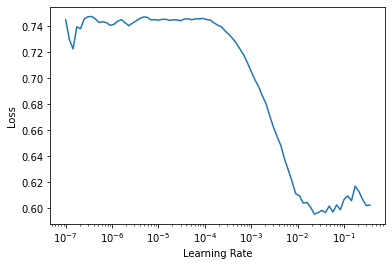

In [54]:
learn.lr_find()

In [55]:
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.375627,0.372117,0.828624,00:06
1,0.361854,0.369475,0.829238,00:06
2,0.351899,0.371077,0.828931,00:06


Can we speed this up a little? Yes we can! The more you can load into a batch, the faster you can process the data. This is a careful balance, for tabular data I go to a maximum of 4096 rows per batch:

In [105]:
dls = to.dataloaders(bs=1024)

In [106]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

(0.025118863582611083, 0.002511886414140463)

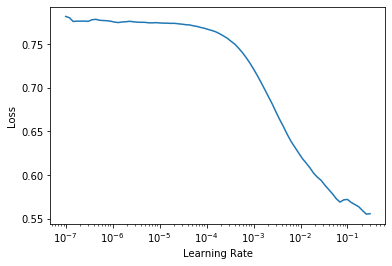

In [ ]:
learn.lr_find()

In [107]:
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.389591,0.409923,0.798833,00:00
1,0.367009,0.351517,0.844748,00:00
2,0.358076,0.350729,0.838913,00:00


We can see we fit very quickly, but it didn't fit quite as well (there is a trade-off):

In [ ]:
dls = to.dataloaders(bs=4096)
learn = tabular_learner(dls, [200,100], metrics=accuracy)

(0.010000000149011612, 0.001737800776027143)

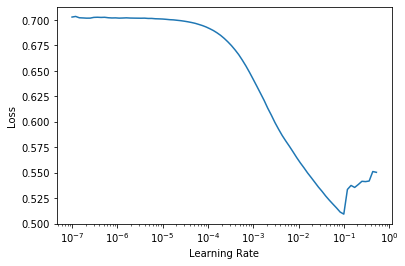

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.524572,0.557502,0.757371,00:00
1,0.443588,0.479469,0.774877,00:00
2,0.411876,0.455629,0.766892,00:00


In [23]:
dls = to.dataloaders(bs=512)
learn = tabular_learner(dls, [200,100], metrics=accuracy)

In [24]:
learn.fit_one_cycle(10,1e-2,wd=0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.405508,0.435672,0.799754,00:00
1,0.374101,0.361316,0.829545,00:00
2,0.362826,0.363138,0.832617,00:00
3,0.356534,0.355196,0.838759,00:00
4,0.353288,0.354103,0.840295,00:00
5,0.348391,0.353521,0.838298,00:00
6,0.343448,0.352366,0.839988,00:00
7,0.336952,0.350874,0.839066,00:00
8,0.329853,0.354238,0.837224,00:00
9,0.324779,0.353378,0.837991,00:00


# 测试集合推理

Now let's look at inference. We'll completely export and load a new learner in:

In [25]:
learn.export('myModel.pkl')

In [26]:
del learn

In [27]:
learn = load_learner('myModel.pkl')

Once we load in our learner, we can create a test dataloader like so:

In [28]:
dl = learn.dls.test_dl(df.iloc[:100])

Let's look at a batch

In [29]:
dl.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101319.996979,12.0,>=50k
1,Private,Masters,Divorced,Exec-managerial,Not-in-family,White,False,44.0,236745.999599,14.0,>=50k
2,Private,HS-grad,Divorced,#na#,Unmarried,Black,True,38.0,96185.001683,10.0,<50k
3,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,False,38.0,112847.002337,15.0,>=50k
4,Self-emp-not-inc,7th-8th,Married-civ-spouse,Other-service,Wife,Black,True,42.0,82296.999507,10.0,<50k
5,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,False,20.0,63209.996678,9.0,<50k
6,Private,Some-college,Divorced,#na#,Other-relative,White,False,49.0,44434.003130,10.0,<50k
7,Private,11th,Married-civ-spouse,#na#,Husband,White,False,37.0,138940.000014,7.0,<50k
8,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,46.0,328215.998539,9.0,>=50k
9,Self-emp-inc,HS-grad,Married-civ-spouse,#na#,Husband,White,True,36.0,216711.000184,10.0,>=50k


You can see it's actually labelled! Is that right?

In [30]:
df2 = df.iloc[:100].drop('salary', axis=1)

In [31]:
df2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States


In [32]:
dl2 = learn.dls.test_dl(df2)

And now we can pass either into our `learn`! (You can't do `validate` on a `test_dl` that did not have ground truth labels)

In [33]:
learn.validate(dl=dl2)

(#2) [None,None]

In [34]:
learn.predict(df2.iloc[0])

(   workclass  education  marital-status  occupation  relationship  race  \
 0        5.0        8.0             3.0         0.0           6.0   5.0   
 
    education-num_na       age    fnlwgt  education-num  salary  
 0               1.0  0.764944 -0.840876         0.7507     1.0  ,
 tensor(1),
 tensor([0.4408, 0.5592]))

### 批量预测

In [35]:
preds = learn.get_preds(dl=dl2)